Importing required libraries

In [6]:
import pandas as pd
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

Loading the data

In [9]:
train_df = pd.read_csv('kdd_train_final.csv')
test_df = pd.read_csv('kdd_test_final.csv')

In [11]:
train_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_encoded,service_encoded,flag_encoded,attack_binary
0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.17,0.00,0.00,0.00,0.05,0.00,1.0,20.0,9.0,0
1,0.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.88,0.00,0.00,0.00,0.00,0.00,2.0,44.0,9.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,1.00,1.00,0.00,0.00,1.0,49.0,5.0,1
3,0.0,232.0,8153.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.03,0.04,0.03,0.01,0.00,0.01,1.0,24.0,9.0,0
4,0.0,199.0,420.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,1.0,24.0,9.0,0


In [13]:
TARGET_COLUMN = 'attack_binary' 
FEATURE_COLUMNS = [col for col in train_df.columns if col != TARGET_COLUMN]

Splitting the data

In [16]:
X_train = train_df[FEATURE_COLUMNS]
y_train = train_df[TARGET_COLUMN]
X_test = test_df[FEATURE_COLUMNS]
y_test = test_df[TARGET_COLUMN]

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
print(f"Data loaded and prepared for {len(FEATURE_COLUMNS)} features and target '{TARGET_COLUMN}'.\n")

Data loaded and prepared for 41 features and target 'attack_binary'.



Creating a dictionary to save all the models

In [24]:
models = {
    "Linear Regression (OLS)": LinearRegression(), 
    "Gradient Descent (SGD)": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42), 
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

In [26]:
results = {}

In [30]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # --- Fit ---
    if name in ["Gradient Descent (SGD)", "Linear Regression (OLS)"]:
        # Use scaled data for gradient-based models
        model.fit(X_train_scaled, y_train)
        y_pred_continuous = model.predict(X_test_scaled)
        # Convert continuous → binary using threshold 0.5
        y_pred = (y_pred_continuous >= 0.5).astype(int)
    else:
        # Tree-based models don't need scaling
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # --- Metrics (safe now) ---
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # --- Store ---
    results[name] = {
        "confusion_matrix": cm,
        "accuracy": acc,
        "classification_report": report,
        "y_pred": y_pred
    }
    
    # --- Print ---
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("-" * 50)


--- Training Linear Regression (OLS) ---
Accuracy: 0.8961
Confusion Matrix:
 [[10789   456]
 [ 1887  9412]]
--------------------------------------------------

--- Training Gradient Descent (SGD) ---
Accuracy: 0.5563
Confusion Matrix:
 [[5725 5520]
 [4482 6817]]
--------------------------------------------------

--- Training Decision Tree ---
Accuracy: 0.9332
Confusion Matrix:
 [[11147    98]
 [ 1407  9892]]
--------------------------------------------------

--- Training Random Forest ---
Accuracy: 0.9291
Confusion Matrix:
 [[11156    89]
 [ 1510  9789]]
--------------------------------------------------


In [31]:
def plot_cm(name):
    cm = results[name]["confusion_matrix"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Normal (0)", "Attack (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} – Confusion Matrix")
    plt.show()



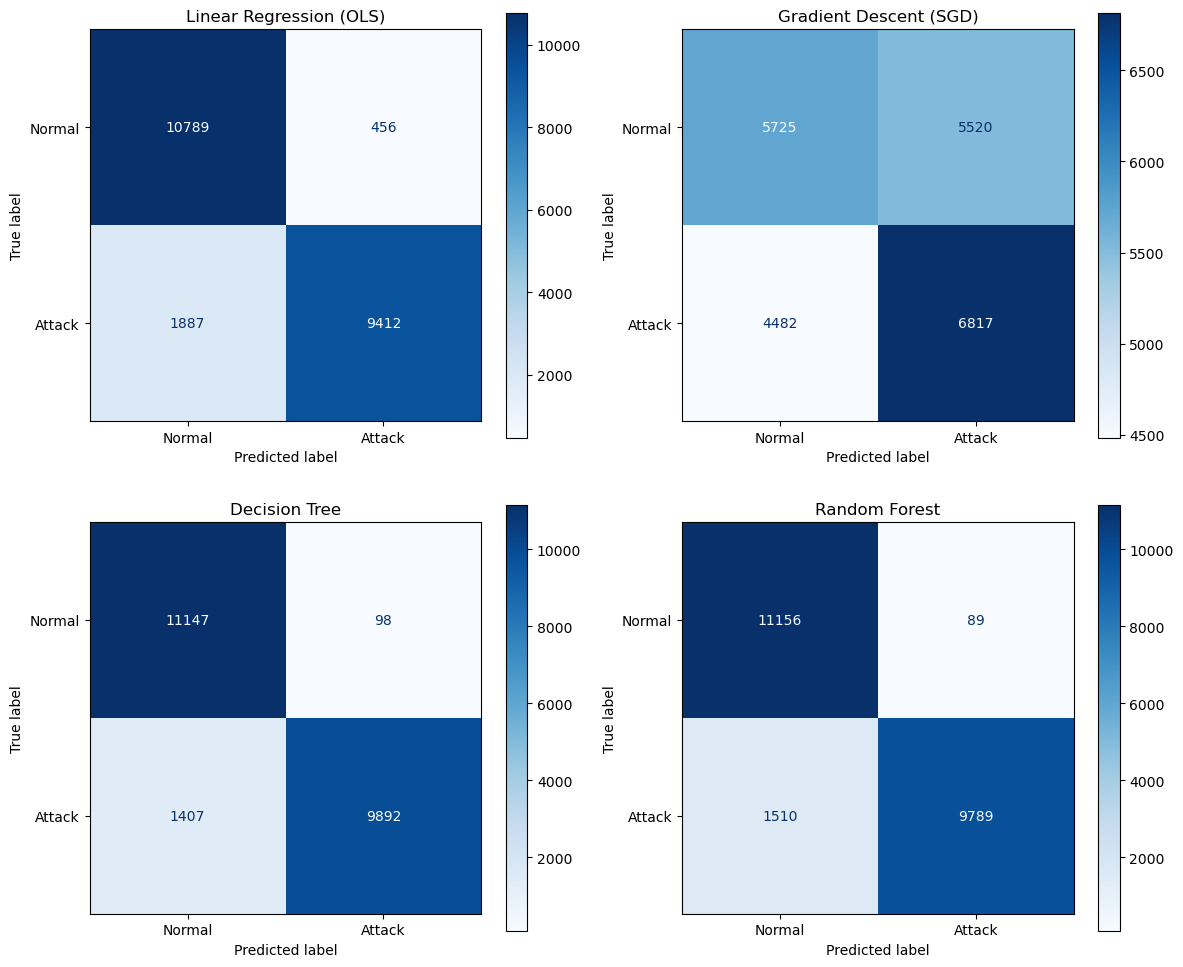

In [34]:
# plot_cm("Random Forest")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
for idx, name in enumerate(models.keys()):
    cm = results[name]["confusion_matrix"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Normal", "Attack"])
    disp.plot(ax=axes[idx], cmap="Blues")
    axes[idx].set_title(name)
plt.tight_layout()
plt.show()